In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Import Data

In [ ]:
url = 'https://query1.finance.yahoo.com/v7/finance/download/ICBP.JK?period1=1491177600&period2=1648944000&interval=1d&events=history&includeAdjustedClose=true'
icbp = pd.read_csv(url)
icbp['Date'] = pd.to_datetime(icbp['Date'])
icbp = icbp[~icbp.Date.duplicated()]
# icbp = icbp.set_index(['Date']).asfreq('D').fillna(method='ffill')
icbp

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-04-03,8200.0,8450.0,8200.0,8425.0,7429.059570,2068600.0
1,2017-04-04,8400.0,8425.0,8275.0,8400.0,7407.015625,3444200.0
2,2017-04-05,8400.0,8400.0,8400.0,8400.0,7407.015625,0.0
3,2017-04-06,8300.0,8325.0,8200.0,8225.0,7252.702637,10471800.0
4,2017-04-07,8200.0,8225.0,8150.0,8175.0,7208.612793,7078600.0
...,...,...,...,...,...,...,...
1255,2022-03-28,7250.0,7400.0,7200.0,7275.0,7275.000000,13828500.0
1256,2022-03-29,7300.0,7400.0,7250.0,7300.0,7300.000000,9243600.0
1257,2022-03-30,7350.0,7475.0,7325.0,7375.0,7375.000000,9768800.0
1258,2022-03-31,7400.0,7450.0,7300.0,7350.0,7350.000000,6875300.0


In [ ]:
icbp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1260 entries, 0 to 1259
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1260 non-null   datetime64[ns]
 1   Open       1259 non-null   float64       
 2   High       1259 non-null   float64       
 3   Low        1259 non-null   float64       
 4   Close      1259 non-null   float64       
 5   Adj Close  1259 non-null   float64       
 6   Volume     1259 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 78.8 KB


In [ ]:
icbp.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,9361.119936,9453.733122,9250.734710,9352.521843,8847.075132,6.206952e+06
std,1048.674051,1057.053850,1033.571492,1046.643271,1077.616521,7.947993e+06
min,7250.000000,7400.000000,7200.000000,7250.000000,7142.479492,0.000000e+00
25%,8675.000000,8750.000000,8550.000000,8650.000000,7962.741455,2.861350e+06
50%,8900.000000,8975.000000,8800.000000,8900.000000,8550.000000,4.626600e+06
75%,10075.000000,10175.000000,9950.000000,10075.000000,9620.093750,7.381550e+06
max,12500.000000,12550.000000,12275.000000,12400.000000,11810.808594,2.044506e+08


In [ ]:
icbp['Date'].min()

Timestamp('2017-04-03 00:00:00')

In [ ]:
# create valid date range
start = icbp['Date'].min()
end = icbp['Date'].max()

# find rows between start and end time and find the first row (00:00 monday morning)
weekly_rows = icbp[(icbp['Date'] >= start) & (icbp['Date'] <= end)].groupby([pd.Grouper(key='Date', freq='W-MON')]).first().reset_index()
weekly_rows.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-04-03,8200.0,8450.0,8200.0,8425.0,7429.060547,2068600.0
1,2017-04-10,8400.0,8425.0,8275.0,8400.0,7407.015625,3444200.0
2,2017-04-17,8200.0,8225.0,8100.0,8125.0,7164.523438,7277700.0
3,2017-04-24,8175.0,8200.0,8075.0,8200.0,7230.657715,7389500.0
4,2017-05-01,8450.0,8500.0,8375.0,8500.0,7495.194824,6203900.0


In [ ]:
weekly_rows.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
257,2022-03-07,8500.0,8525.0,8150.0,8250.0,8250.0,21470900.0
258,2022-03-14,7400.0,7600.0,7400.0,7600.0,7600.0,21825800.0
259,2022-03-21,7525.0,7600.0,7375.0,7425.0,7425.0,15064300.0
260,2022-03-28,7475.0,7600.0,7475.0,7475.0,7475.0,4588300.0
261,2022-04-04,7300.0,7400.0,7250.0,7300.0,7300.0,9243600.0


In [ ]:
!pip install plotly==5.6.0

     |████████████████████████████████| 27.7 MB 1.6 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 5.5.0
    Uninstalling plotly-5.5.0:
      Successfully uninstalled plotly-5.5.0


In [ ]:
!pip install chart-studio

     |████████████████████████████████| 64 kB 1.9 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=825630794617ba3f623db6f570944e3b426511eace637019d4ea88cee05b1999
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [ ]:
from plotly import tools
import chart_studio.plotly as py
import plotly.graph_objs as go
import gc
from plotly.offline import init_notebook_mode, iplot
# init_notebook_mode(connected=True)

In [ ]:
trace1 = go.Scatter(
    x = weekly_rows['Date'],
    y = weekly_rows['Open'].astype(float),
    mode = 'lines',
    name = 'Open'
)

trace2 = go.Scatter(
    x = weekly_rows['Date'],
    y = weekly_rows['Close'].astype(float),
    mode = 'lines',
    name = 'Close'
)
# trace3 = go.Scatter(
#     x = weekly_rows['Date'],
#     y = weekly_rows['Adj Close'].astype(float),
#     mode = 'lines',
#     name = 'Adj Close'
# )

layout = dict(
    title='Historical ICBP Prices (2017-2022) with the Slider ',
    hovermode='x',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                #change the count to desired amount of months.
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

# data = [trace1,trace2, trace3]
data = [trace1,trace2]
fig = dict(data=data, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider")
# fig.show()

In [ ]:
trace1 = go.Scatter(
    x = weekly_rows['Date'],
    y = weekly_rows['Volume'].astype(float),
    mode = 'lines',
    name = 'Volume'
)

layout = dict(
    title='Historical ICBP Volume (IDR) (2017-2022) with the slider',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

data = [trace1]
fig = dict(data=data, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider")

In [ ]:
trace = go.Scattergl(
    y = weekly_rows['Volume'].astype(float),
    x = weekly_rows['Close'].astype(float),
    mode = 'markers',
    marker = dict(
        color = '#FFBAD2',
        line = dict(width = 1)
    )
)
layout = go.Layout(
    title='ICBP Volume v/s IDR',
    xaxis=dict(
        title='Price',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Volume',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )))
data = [trace]
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='compare_webgl')

# Eksplorasi Data

In [ ]:
icbp2 = icbp.set_index(['Date']).asfreq('D').fillna(method='ffill')

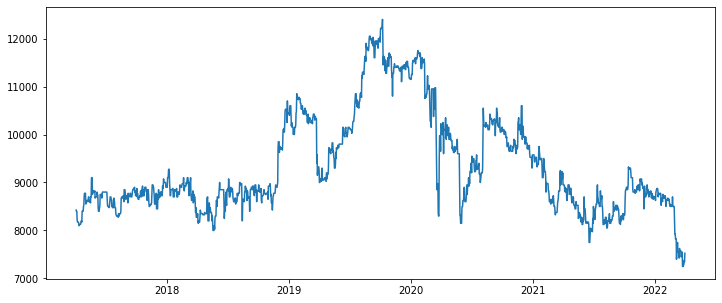

In [ ]:
ts = icbp2['Close']
plt.figure(figsize=(12,5))
plt.plot(ts)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


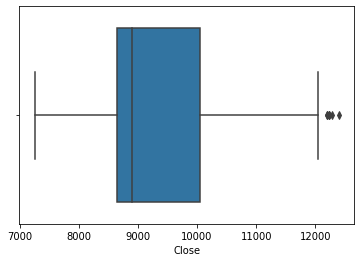

In [ ]:
sns.boxplot(ts)

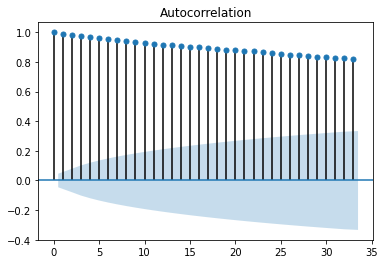

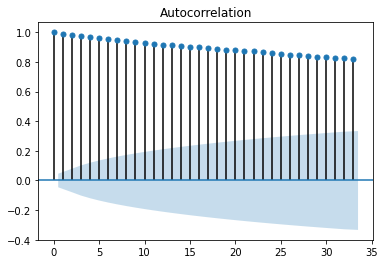

In [ ]:
plot_acf(ts)

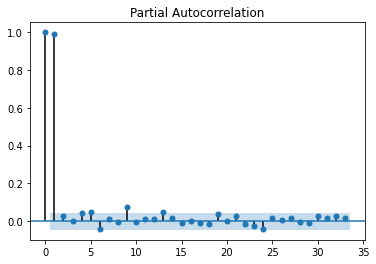

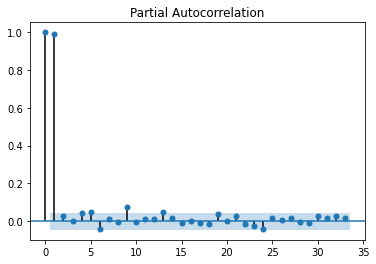

In [ ]:
plot_pacf(ts)

# Split Data

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
def train_test_split_sequence(ts, prop_train=.8):
  split_point = round(prop_train * len(ts))
  train, test = ts[:split_point+1], ts[split_point+1:]
  return train, test

def input_output_split_sequence(seq, n_steps):
  X, y = [], []
  for i in range(len(seq)):
    end_ix = i + n_steps
    if end_ix > len(seq) - 1:
      break
    seq_x, seq_y = seq[i:end_ix], seq[end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

def split_sequence(seq, n_steps=1):
  X, y = [], []
  for i in range(len(seq)-n_steps-1):
    v = seq[i:(i+n_steps), 0]
    X.append(v)
    y.append(seq[i + n_steps, 0])
  return np.array(X), np.array(y)

## Split LSTM

In [ ]:
ts = icbp2[['Close']]

ts.values

array([[8425.],
       [8400.],
       [8400.],
       ...,
       [7375.],
       [7350.],
       [7525.]])

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
ts = scaler.fit_transform(ts)

ts

array([[0.22815534],
       [0.22330097],
       [0.22330097],
       ...,
       [0.02427184],
       [0.01941748],
       [0.05339806]])

In [ ]:
ts.shape

(1825, 1)

In [ ]:
train, test = train_test_split_sequence(ts)

output = f'''
Train: 
{train.shape}

Text:
{test.shape}
'''
print(output)


Train: 
(1461, 1)

Text:
(364, 1)



In [ ]:
X_train, y_train = split_sequence(train, n_steps=5)
X_test, y_test = split_sequence(test, n_steps=5)

output = f'''
X train ({X_train.shape}): 
{X_train}

y train ({y_train.shape}):
{y_train}
'''
print(output)


X train ((1455, 5)): 
[[0.22815534 0.22330097 0.22330097 0.18932039 0.17961165]
 [0.22330097 0.22330097 0.18932039 0.17961165 0.17961165]
 [0.22330097 0.18932039 0.17961165 0.17961165 0.17961165]
 ...
 [0.33009709 0.3592233  0.3592233  0.3592233  0.38349515]
 [0.3592233  0.3592233  0.3592233  0.38349515 0.35436893]
 [0.3592233  0.3592233  0.38349515 0.35436893 0.37864078]]

y train ((1455,)):
[0.17961165 0.17961165 0.17961165 ... 0.35436893 0.37864078 0.33009709]



In [ ]:
y_train.shape

(1455,)

In [ ]:
X_train.shape

(1455, 5)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
X_train.shape

(1455, 1, 5)

## Split CNN

In [ ]:
ts2 = icbp2[['Close']]

In [ ]:
ts2

,Close
Date,
2017-04-03,8425.0
2017-04-04,8400.0
2017-04-05,8400.0
2017-04-06,8225.0
2017-04-07,8175.0
...,...
2022-03-28,7275.0
2022-03-29,7300.0
2022-03-30,7375.0


In [ ]:
ts2.shape

(1825, 1)

In [ ]:
ts2 = scaler.fit_transform(ts2)

In [ ]:
train2, test2 = train_test_split_sequence(ts2)

output = f'''
Train: 
{train2}

Text:
{test2}
'''
print(output)


Train: 
[[0.22815534]
 [0.22330097]
 [0.22330097]
 ...
 [0.37864078]
 [0.33009709]
 [0.33009709]]

Text:
[[0.33009709]
 [0.33009709]
 [0.32524272]
 [0.30582524]
 [0.32038835]
 [0.30097087]
 [0.31553398]
 [0.31553398]
 [0.31553398]
 [0.27184466]
 [0.26699029]
 [0.29126214]
 [0.29126214]
 [0.33009709]
 [0.33009709]
 [0.33009709]
 [0.33009709]
 [0.32038835]
 [0.30097087]
 [0.29126214]
 [0.31553398]
 [0.31553398]
 [0.31553398]
 [0.2815534 ]
 [0.26213592]
 [0.25728155]
 [0.26699029]
 [0.2815534 ]
 [0.2815534 ]
 [0.2815534 ]
 [0.25242718]
 [0.24757282]
 [0.24757282]
 [0.24271845]
 [0.23300971]
 [0.23300971]
 [0.23300971]
 [0.26213592]
 [0.24757282]
 [0.24757282]
 [0.24757282]
 [0.24757282]
 [0.24757282]
 [0.24757282]
 [0.19417476]
 [0.2038835 ]
 [0.19902913]
 [0.2184466 ]
 [0.20873786]
 [0.20873786]
 [0.20873786]
 [0.18446602]
 [0.17961165]
 [0.17961165]
 [0.19902913]
 [0.16990291]
 [0.16990291]
 [0.16990291]
 [0.18446602]
 [0.18446602]
 [0.18932039]
 [0.2815534 ]
 [0.23300971]
 [0.23300971

In [ ]:
train2.shape

(1461, 1)

In [ ]:
X_train2, y_train2 = input_output_split_sequence(train2, n_steps=5)
X_test2, y_test2 = input_output_split_sequence(test2, n_steps=5)

output = f'''
X train ({X_train2.shape}): 
{X_train2}

y train ({y_train2.shape}):
{y_train2}
'''
print(output)


X train ((1456, 5, 1)): 
[[[0.22815534]
  [0.22330097]
  [0.22330097]
  [0.18932039]
  [0.17961165]]

 [[0.22330097]
  [0.22330097]
  [0.18932039]
  [0.17961165]
  [0.17961165]]

 [[0.22330097]
  [0.18932039]
  [0.17961165]
  [0.17961165]
  [0.17961165]]

 ...

 [[0.3592233 ]
  [0.3592233 ]
  [0.3592233 ]
  [0.38349515]
  [0.35436893]]

 [[0.3592233 ]
  [0.3592233 ]
  [0.38349515]
  [0.35436893]
  [0.37864078]]

 [[0.3592233 ]
  [0.38349515]
  [0.35436893]
  [0.37864078]
  [0.33009709]]]

y train ((1456, 1)):
[[0.17961165]
 [0.17961165]
 [0.17961165]
 ...
 [0.37864078]
 [0.33009709]
 [0.33009709]]



In [ ]:
X_train2.shape

(1456, 5, 1)

# Model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
# from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Reshape
from keras.layers import Dropout
from keras.layers import Bidirectional
from keras.layers.convolutional import Conv1D
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 29.6 MB/s 


In [ ]:
import keras_tuner as kt

## Vanilla LSTM

### Model

In [ ]:
def model_builder(hp):
  model = Sequential()

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units_lstm = hp.Int('units_lstm', min_value=32, max_value=512, step=32)
  model.add(LSTM(hp_units_lstm, activation='relu', input_shape=(1, 5)))
  model.add(Dense(1))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='mse')

  return model

In [ ]:
tuner = kt.RandomSearch(model_builder,
                     objective='val_loss',
                     max_trials=15,
                     seed=42,
                     executions_per_trial=2,
                     directory='icbp',
                     project_name='vanilla-lstm'
                    # # FOR TRAIN ONLY
                    #  overwrite=True
                    # # --------------
                     )

In [ ]:
tuner.search(X_train, y_train, epochs=50, validation_split=0.2)

Trial 15 Complete [00h 01m 06s]
val_loss: 0.0006290480960160494

Best val_loss So Far: 0.0006290480960160494
Total elapsed time: 00h 13m 03s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

tuning = ['units_lstm', 'learning_rate']
print('Best tune:')
for tune in tuning:
  print(f'{tune}: {best_hps.get(tune)}')

Best tune:
units_lstm: 416
learning_rate: 0.01


In [ ]:
tuner.results_summary(num_trials=15)

Results summary
Results in icbp/vanilla-lstm
Showing 15 best trials
Trial summary
Hyperparameters:
units_lstm: 416
learning_rate: 0.01
Score: 0.0006290480960160494
Trial summary
Hyperparameters:
units_lstm: 288
learning_rate: 0.01
Score: 0.0006307681032922119
Trial summary
Hyperparameters:
units_lstm: 320
learning_rate: 0.01
Score: 0.0006308612937573344
Trial summary
Hyperparameters:
units_lstm: 256
learning_rate: 0.01
Score: 0.0006334111385513097
Trial summary
Hyperparameters:
units_lstm: 480
learning_rate: 0.01
Score: 0.0006337461236398667
Trial summary
Hyperparameters:
units_lstm: 352
learning_rate: 0.01
Score: 0.0006349830946419388
Trial summary
Hyperparameters:
units_lstm: 64
learning_rate: 0.01
Score: 0.0006434762908611447
Trial summary
Hyperparameters:
units_lstm: 192
learning_rate: 0.001
Score: 0.0006800858827773482
Trial summary
Hyperparameters:
units_lstm: 480
learning_rate: 0.001
Score: 0.0006812568753957748
Trial summary
Hyperparameters:
units_lstm: 224
learning_rate: 0.001

In [ ]:
best_hp = tuner.get_best_hyperparameters()[0]
lstm = tuner.hypermodel.build(best_hp)

lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 416)               702208    
                                                                 
 dense_1 (Dense)             (None, 1)                 417       
                                                                 
Total params: 702,625
Trainable params: 702,625
Non-trainable params: 0
_________________________________________________________________


In [ ]:
historylstm = lstm.fit(X_train, y_train,
                       epochs=50,
                       validation_data=(X_test, y_test), 
                       verbose=2)

Epoch 1/50
46/46 - 2s - loss: 0.0192 - val_loss: 0.0014 - 2s/epoch - 40ms/step
Epoch 2/50
46/46 - 0s - loss: 0.0014 - val_loss: 0.0012 - 430ms/epoch - 9ms/step
Epoch 3/50
46/46 - 0s - loss: 0.0013 - val_loss: 0.0011 - 444ms/epoch - 10ms/step
Epoch 4/50
46/46 - 1s - loss: 0.0012 - val_loss: 7.4880e-04 - 503ms/epoch - 11ms/step
Epoch 5/50
46/46 - 0s - loss: 0.0011 - val_loss: 5.8614e-04 - 470ms/epoch - 10ms/step
Epoch 6/50
46/46 - 0s - loss: 0.0010 - val_loss: 5.4576e-04 - 474ms/epoch - 10ms/step
Epoch 7/50
46/46 - 0s - loss: 9.1795e-04 - val_loss: 7.1273e-04 - 423ms/epoch - 9ms/step
Epoch 8/50
46/46 - 0s - loss: 8.7762e-04 - val_loss: 6.0612e-04 - 447ms/epoch - 10ms/step
Epoch 9/50
46/46 - 0s - loss: 9.3845e-04 - val_loss: 7.7285e-04 - 431ms/epoch - 9ms/step
Epoch 10/50
46/46 - 0s - loss: 8.6030e-04 - val_loss: 4.5801e-04 - 469ms/epoch - 10ms/step
Epoch 11/50
46/46 - 0s - loss: 8.3522e-04 - val_loss: 4.6917e-04 - 468ms/epoch - 10ms/step
Epoch 12/50
46/46 - 0s - loss: 8.7012e-04 - val_lo

In [ ]:
lstm.save('vanilla_lstm.h5')

### Evaluation

In [ ]:
train_predict = lstm.predict(X_train)
test_predict = lstm.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
train_y = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
test_y = scaler.inverse_transform([y_test])

In [ ]:
def metrics_evaluation_regression(test, predict):
  metrics = pd.DataFrame({
      'MSE': [mean_squared_error(test, predict)],
      'RMSE': [np.sqrt(mean_squared_error(test, predict))],
      'MAE': [mean_absolute_error(test, predict)],
      'MAPE': [mean_absolute_percentage_error(test, predict)]
  })
  return metrics 

In [ ]:
metrics_evaluation_regression(train_y[0], train_predict)

,MSE,RMSE,MAE,MAPE
0,29094.728667,170.57177,130.323547,0.013284


In [ ]:
metrics_evaluation_regression(test_y[0], test_predict)

,MSE,RMSE,MAE,MAPE
0,16603.909363,128.856158,90.679217,0.010844


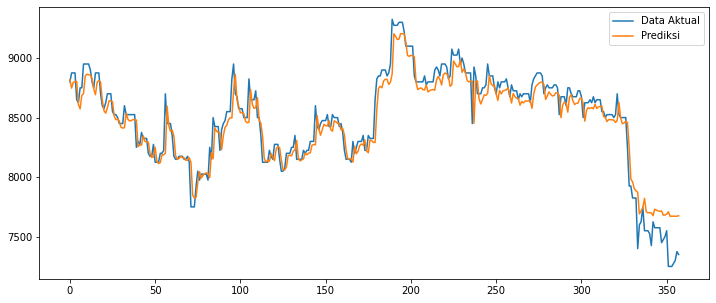

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(test_y[0])
plt.plot(test_predict)
plt.legend(['Data Aktual', 'Prediksi'])

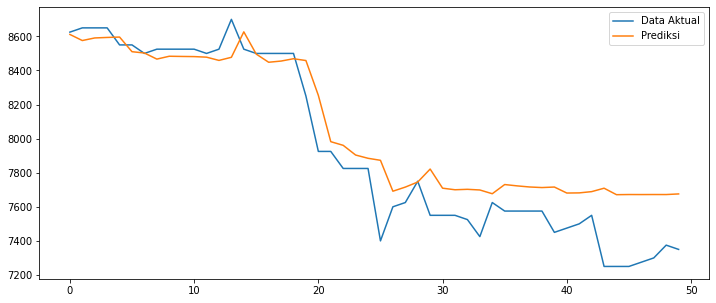

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(test_y[0][-50:])
plt.plot(test_predict[-50:])
plt.legend(['Data Aktual', 'Prediksi'])

## CNN-LSTM

### Model

In [72]:
def cnnlstm_builder(hp):
  n_steps, n_features = 5, 1
  model = Sequential()

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_filter = hp.Int('units_filter', min_value=32, max_value=512, step=32)
  hp_units_lstm = hp.Int('units_lstm', min_value=32, max_value=512, step=32)
  model.add(Reshape((n_steps, n_features), input_dim=n_steps))
  model.add(Conv1D(filters=hp_filter, kernel_size=2, activation='relu'))
  model.add(LSTM(hp_units_lstm, activation='relu'))
  model.add(Dense(1))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='mse')

  return model

In [74]:
cnntuner = kt.RandomSearch(cnnlstm_builder,
                     objective='val_loss',
                     max_trials=15,
                     seed=42,
                     executions_per_trial=2,
                     directory='icbp',
                     overwrite=True,
                     project_name='cnn-lstm'
                    # # FOR TRAIN ONLY
                    # # --------------
                     )

In [75]:
cnntuner.search(X_train2, y_train2, epochs=50, validation_split=0.2)

Trial 15 Complete [00h 01m 25s]
val_loss: 0.0006258178036659956

Best val_loss So Far: 0.0006176525203045458
Total elapsed time: 00h 25m 43s
INFO:tensorflow:Oracle triggered exit


In [76]:
# Get the optimal hyperparameters
best_hps=cnntuner.get_best_hyperparameters(num_trials=1)[0]

tuning = ['units_lstm', 'learning_rate', 'units_filter']
print('Best tune:')
for tune in tuning:
  print(f'{tune}: {best_hps.get(tune)}')

Best tune:
units_lstm: 256
learning_rate: 0.001
units_filter: 256


In [77]:
cnntuner.results_summary(num_trials=10)

Results summary
Results in icbp/cnn-lstm
Showing 10 best trials
Trial summary
Hyperparameters:
units_filter: 256
units_lstm: 256
learning_rate: 0.001
Score: 0.0006176525203045458
Trial summary
Hyperparameters:
units_filter: 352
units_lstm: 480
learning_rate: 0.001
Score: 0.0006194192974362522
Trial summary
Hyperparameters:
units_filter: 256
units_lstm: 224
learning_rate: 0.001
Score: 0.0006206651451066136
Trial summary
Hyperparameters:
units_filter: 160
units_lstm: 448
learning_rate: 0.001
Score: 0.0006233327439986169
Trial summary
Hyperparameters:
units_filter: 384
units_lstm: 128
learning_rate: 0.01
Score: 0.0006258178036659956
Trial summary
Hyperparameters:
units_filter: 288
units_lstm: 96
learning_rate: 0.001
Score: 0.0006263350078370422
Trial summary
Hyperparameters:
units_filter: 64
units_lstm: 320
learning_rate: 0.01
Score: 0.0006283823749981821
Trial summary
Hyperparameters:
units_filter: 288
units_lstm: 64
learning_rate: 0.001
Score: 0.0006296433275565505
Trial summary
Hyperpa

In [78]:
best_hp = cnntuner.get_best_hyperparameters()[0]
lstmcnn = cnntuner.hypermodel.build(best_hp)

lstmcnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 5, 1)              0         
                                                                 
 conv1d_1 (Conv1D)           (None, 4, 256)            768       
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 526,337
Trainable params: 526,337
Non-trainable params: 0
_________________________________________________________________


In [79]:
historylstmncnn = lstmcnn.fit(X_train2, y_train2, epochs=50, validation_data=(X_test2, y_test2))

Epoch 1/50
46/46 [==============================] - 3s 35ms/step - loss: 0.0244 - val_loss: 0.0012
Epoch 2/50
46/46 [==============================] - 1s 29ms/step - loss: 0.0014 - val_loss: 9.4423e-04
Epoch 3/50
46/46 [==============================] - 1s 30ms/step - loss: 0.0013 - val_loss: 9.0892e-04
Epoch 4/50
46/46 [==============================] - 1s 30ms/step - loss: 0.0013 - val_loss: 8.5581e-04
Epoch 5/50
46/46 [==============================] - 1s 30ms/step - loss: 0.0012 - val_loss: 8.4624e-04
Epoch 6/50
46/46 [==============================] - 1s 29ms/step - loss: 0.0012 - val_loss: 8.9062e-04
Epoch 7/50
46/46 [==============================] - 1s 30ms/step - loss: 0.0012 - val_loss: 7.7017e-04
Epoch 8/50
46/46 [==============================] - 1s 30ms/step - loss: 0.0012 - val_loss: 7.2443e-04
Epoch 9/50
46/46 [==============================] - 1s 31ms/step - loss: 0.0011 - val_loss: 6.9770e-04
Epoch 10/50
46/46 [==============================] - 1s 31ms/step - loss: 0.0

In [80]:
lstmcnn.save('cnn_lstm.h5')

### Evaluation

In [81]:
cnn_train = lstmcnn.predict(X_train2)
cnn_test = lstmcnn.predict(X_test2)

cnn_train = scaler.inverse_transform(cnn_train)
train_y = scaler.inverse_transform(y_train2)
cnn_test = scaler.inverse_transform(cnn_test)
test_y = scaler.inverse_transform(y_test2)

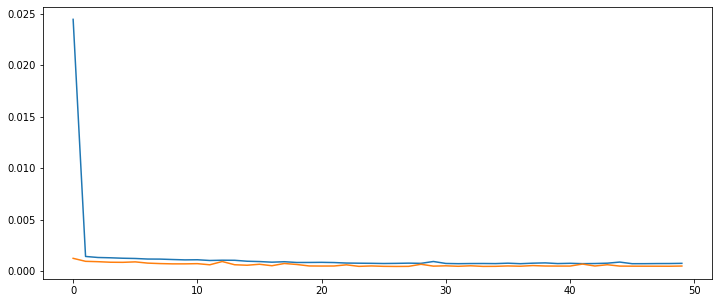

In [82]:
plt.figure(figsize=(12,5))
plt.plot(historylstmncnn.history['loss'][:50])
plt.plot(historylstmncnn.history['val_loss'][:50])

In [83]:
def metrics_evaluation_regression(test, predict):
  metrics = pd.DataFrame({
      'MSE': [mean_squared_error(test, predict)],
      'RMSE': [np.sqrt(mean_squared_error(test, predict))],
      'MAE': [mean_absolute_error(test, predict)],
      'MAPE': [mean_absolute_percentage_error(test, predict)]
  })
  return metrics 

In [84]:
metrics_evaluation_regression(train_y, cnn_train)

,MSE,RMSE,MAE,MAPE
0,17799.764976,133.41576,75.328293,0.007898


In [85]:
metrics_evaluation_regression(test_y, cnn_test)

,MSE,RMSE,MAE,MAPE
0,12909.022088,113.617878,73.801552,0.008897


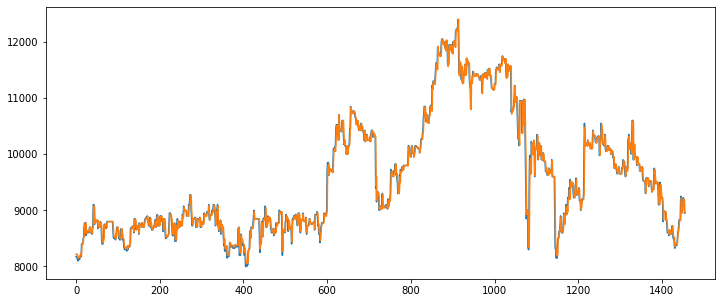

In [86]:
plt.figure(figsize=(12,5))
plt.plot(train_y)
plt.plot(cnn_train)

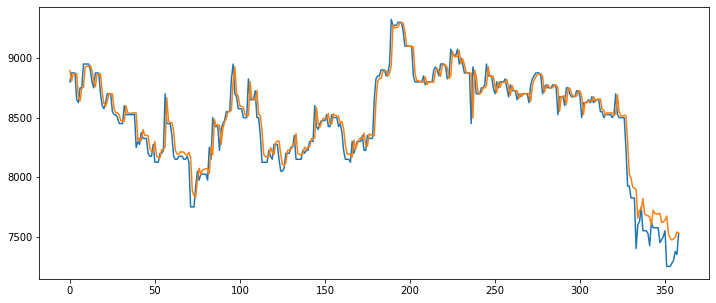

In [87]:
plt.figure(figsize=(12,5))
plt.plot(test_y)
plt.plot(cnn_test)

## BiLSTM

### Model

In [ ]:
def bilstm_builder(hp):
  model = Sequential()

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units_lstm = hp.Int('units_lstm', min_value=32, max_value=512, step=32)
  model.add(Bidirectional(LSTM(hp_units_lstm, activation='relu', input_shape=(1, 5))))
  model.add(Dense(1))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='mse')

  return model

In [ ]:
bilstmtuner = kt.RandomSearch(bilstm_builder,
                     objective='val_loss',
                     max_trials=15,
                     seed=42,
                     executions_per_trial=2,
                     directory='icbp',
                     project_name='bi-lstm'
                    # # FOR TRAIN ONLY
                    #  overwrite=True
                    # # --------------
                     )

In [ ]:
bilstmtuner.search(X_train, y_train, epochs=50, validation_split=0.2)

Trial 15 Complete [00h 01m 21s]
val_loss: 0.0006299819506239146

Best val_loss So Far: 0.0006260778463911265
Total elapsed time: 00h 19m 07s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get the optimal hyperparameters
best_hps=bilstmtuner.get_best_hyperparameters(num_trials=1)[0]

tuning = ['units_lstm', 'learning_rate']
print('Best tune:')
for tune in tuning:
  print(f'{tune}: {best_hps.get(tune)}')

Best tune:
units_lstm: 320
learning_rate: 0.01


In [ ]:
bilstmtuner.results_summary(num_trials=15)

Results summary
Results in icbp/bi-lstm
Showing 15 best trials
Trial summary
Hyperparameters:
units_lstm: 320
learning_rate: 0.01
Score: 0.0006260778463911265
Trial summary
Hyperparameters:
units_lstm: 256
learning_rate: 0.01
Score: 0.000627219385933131
Trial summary
Hyperparameters:
units_lstm: 288
learning_rate: 0.01
Score: 0.0006280052766669542
Trial summary
Hyperparameters:
units_lstm: 416
learning_rate: 0.01
Score: 0.0006299819506239146
Trial summary
Hyperparameters:
units_lstm: 480
learning_rate: 0.01
Score: 0.0006310882745310664
Trial summary
Hyperparameters:
units_lstm: 64
learning_rate: 0.01
Score: 0.00063203094759956
Trial summary
Hyperparameters:
units_lstm: 352
learning_rate: 0.01
Score: 0.0006346528825815767
Trial summary
Hyperparameters:
units_lstm: 480
learning_rate: 0.001
Score: 0.0006557070882990956
Trial summary
Hyperparameters:
units_lstm: 448
learning_rate: 0.001
Score: 0.0006614016892854124
Trial summary
Hyperparameters:
units_lstm: 224
learning_rate: 0.001
Score: 

In [ ]:
best_hp = bilstmtuner.get_best_hyperparameters()[0]
bilstm = bilstmtuner.hypermodel.build(best_hp)

# bilstm.summary()

In [ ]:
historybilstm = bilstm.fit(X_train, y_train, 
                       epochs=50,
                       validation_data=(X_test, y_test), 
                       verbose=2)

Epoch 1/50
46/46 - 3s - loss: 0.0152 - val_loss: 0.0012 - 3s/epoch - 70ms/step
Epoch 2/50
46/46 - 1s - loss: 0.0014 - val_loss: 9.3821e-04 - 545ms/epoch - 12ms/step
Epoch 3/50
46/46 - 1s - loss: 0.0012 - val_loss: 8.8843e-04 - 563ms/epoch - 12ms/step
Epoch 4/50
46/46 - 1s - loss: 0.0011 - val_loss: 7.3538e-04 - 602ms/epoch - 13ms/step
Epoch 5/50
46/46 - 1s - loss: 0.0011 - val_loss: 6.2684e-04 - 944ms/epoch - 21ms/step
Epoch 6/50
46/46 - 1s - loss: 9.9113e-04 - val_loss: 6.4032e-04 - 990ms/epoch - 22ms/step
Epoch 7/50
46/46 - 1s - loss: 9.7503e-04 - val_loss: 5.4886e-04 - 979ms/epoch - 21ms/step
Epoch 8/50
46/46 - 1s - loss: 0.0011 - val_loss: 0.0011 - 715ms/epoch - 16ms/step
Epoch 9/50
46/46 - 1s - loss: 0.0011 - val_loss: 4.8165e-04 - 947ms/epoch - 21ms/step
Epoch 10/50
46/46 - 1s - loss: 8.6319e-04 - val_loss: 4.6852e-04 - 1s/epoch - 22ms/step
Epoch 11/50
46/46 - 1s - loss: 9.7785e-04 - val_loss: 5.9659e-04 - 968ms/epoch - 21ms/step
Epoch 12/50
46/46 - 1s - loss: 8.4669e-04 - val_lo

In [ ]:
bilstm.save('bi_lstm.h5')

### Evaluation

In [ ]:
train_predict2 = bilstm.predict(X_train)
test_predict2 = bilstm.predict(X_test)

train_predict2 = scaler.inverse_transform(train_predict2)
# train_y = scaler.inverse_transform([y_train])
test_predict2 = scaler.inverse_transform(test_predict2)
# test_y = scaler.inverse_transform([y_test])

In [ ]:
def metrics_evaluation_regression(test, predict):
  metrics = pd.DataFrame({
      'MSE': [mean_squared_error(test, predict)],
      'RMSE': [np.sqrt(mean_squared_error(test, predict))],
      'MAE': [mean_absolute_error(test, predict)],
      'MAPE': [mean_absolute_percentage_error(test, predict)]
  })
  return metrics 

In [ ]:
metrics_evaluation_regression(train_y[0], train_predict2)

,MSE,RMSE,MAE,MAPE
0,26931.047769,164.106818,124.839657,0.012824


In [ ]:
metrics_evaluation_regression(test_y[0], test_predict2)

,MSE,RMSE,MAE,MAPE
0,19136.665756,138.335338,98.103473,0.011776


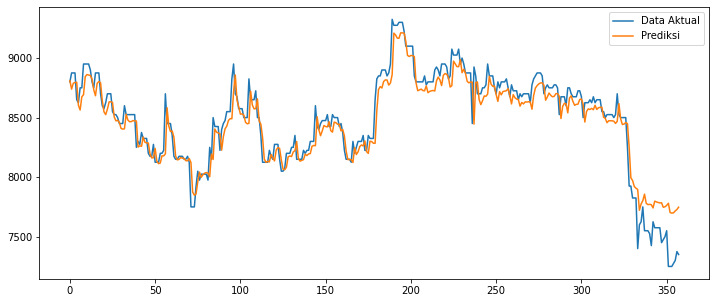

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(test_y[0])
plt.plot(test_predict2)
plt.legend(['Data Aktual', 'Prediksi'])

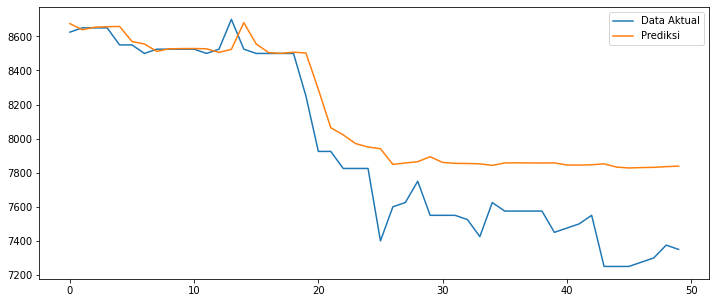

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(test_y[0][-50:])
plt.plot(test_predict2[-50:])
plt.legend(['Data Aktual', 'Prediksi'])

# Perbandingan

## Vanilla

In [ ]:
metrics_evaluation_regression(train_y[0], train_predict)

,MSE,RMSE,MAE,MAPE
0,22317.417773,149.390153,100.44915,0.010407


In [ ]:
metrics_evaluation_regression(test_y[0], test_predict)

,MSE,RMSE,MAE,MAPE
0,14976.625376,122.379023,87.167432,0.010493


## CNN-LSTM

In [ ]:
metrics_evaluation_regression(y_train2, lstmcnn.predict(X_train2))

,MSE,RMSE,MAE,MAPE
0,19680.56353,140.287432,84.143688,0.008833


In [ ]:
metrics_evaluation_regression(y_test2, lstmcnn.predict(X_test2))

,MSE,RMSE,MAE,MAPE
0,11903.910186,109.105042,71.649232,0.008518


## BiLSTM

In [ ]:
metrics_evaluation_regression(train_y[0], train_predict2)

,MSE,RMSE,MAE,MAPE
0,17973.617383,134.06572,78.633088,0.008204


In [ ]:
metrics_evaluation_regression(test_y[0], test_predict2)

,MSE,RMSE,MAE,MAPE
0,11413.950255,106.836091,67.162503,0.008017


## Chart 

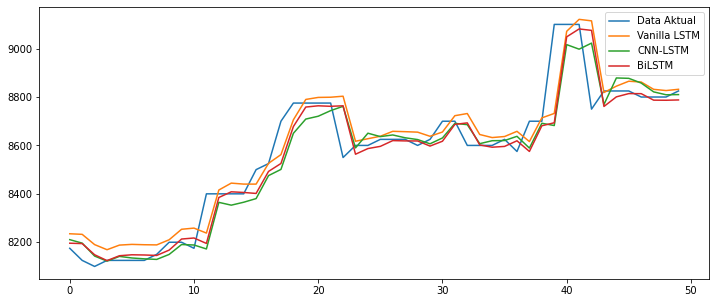

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(train_y[0][:50])
plt.plot(train_predict[:50])
plt.plot(cnn_train[:50])
plt.plot(train_predict2[:50])
plt.legend(['Data Aktual', 'Vanilla LSTM', 'CNN-LSTM', 'BiLSTM'])

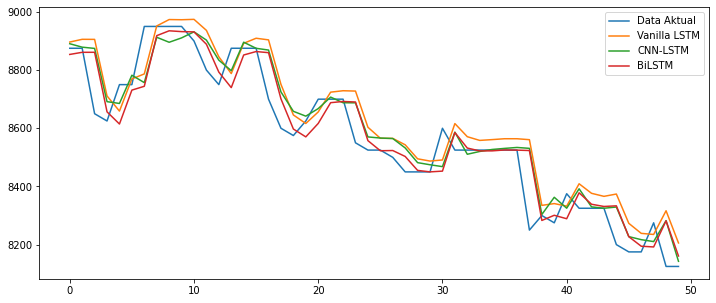

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(test_y[0][:50])
plt.plot(test_predict[:50])
plt.plot(cnn_test[:50])
plt.plot(test_predict2[:50])
plt.legend(['Data Aktual', 'Vanilla LSTM', 'CNN-LSTM', 'BiLSTM'])

In [ ]:
trace1 = go.Scatter(
    x = weekly_rows['Date'],
    y = test_y[0].astype(float),
    mode = 'lines',
    name = 'Data Aktual'
)

trace2 = go.Scatter(
    x = weekly_rows['Date'],
    y = np.ravel(test_predict).astype(float),
    mode = 'lines',
    name = 'Vanilla LSTM'
)

trace3 = go.Scatter(
    x = weekly_rows['Date'],
    y = np.ravel(cnn_test).astype(float),
    mode = 'lines',
    name = 'CNN-LSTM'
)

trace4 = go.Scatter(
    x = weekly_rows['Date'],
    y = np.ravel(test_predict2).astype(float),
    mode = 'lines',
    name = 'Bi-LSTM'
)

layout = dict(
    title='ICBP Prices Test Prediction (2017-2022) with the Slider ',
    hovermode='x',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                #change the count to desired amount of months.
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

# data = [trace1,trace2, trace3]
data = [trace1,trace2,trace3,trace4]
fig = dict(data=data, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider")
# fig.show()

# Feature Importance

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, scoring="r2", random_state=1).fit(X_train,y_train)
eli5.show_weights(perm, feature_names = [f'lag-{7-i}' for i in range(7)])

Weight,Feature
0.0700 ± 0.0144,lag-2
0.0683 ± 0.0113,lag-5
0.0652 ± 0.0146,lag-4
0.0651 ± 0.0129,lag-6
0.0612 ± 0.0104,lag-3
0.0227 ± 0.0025,lag-1
0.0108 ± 0.0018,lag-7


In [ ]:
 [f'lag-{7-i}' for i in range(7)]

['lag-7', 'lag-6', 'lag-5', 'lag-4', 'lag-3', 'lag-2', 'lag-1']

# Hyperparameter Tuning

In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 5.2 MB/s 


In [ ]:
import keras_tuner as kt

In [ ]:
def model_builder(hp):
  n_steps, n_features = 7, 1
  model = Sequential()

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_filter = hp.Int('units_filter', min_value=8, max_value=512, step=32)
  hp_units_lstm = hp.Int('units_lstm', min_value=8, max_value=512, step=32)
  hp_units_dense = hp.Int('units_dense', min_value=8, max_value=512, step=32)
  model.add(Reshape((n_steps, n_features), input_dim=n_steps))
  model.add(Conv1D(filters=hp_filter, kernel_size=2, activation='relu'))
  model.add(LSTM(hp_units_lstm, activation='relu'))
  model.add(Dense(hp_units_dense, activation='relu'))
  model.add(Dense(1))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='mse')

  return model

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
n_steps, n_features = 7, 1
X, y = input_output_split_sequence(ts, n_steps)

tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='cnn-lstm_model',
                     project_name='during_covid',
                    # # FOR TRAIN ONLY
                    #  overwrite=True
                    # # --------------
                     )

tuner.search(X, y, epochs=50, callbacks=[stop_early], validation_split=0.2,)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

tuning = ['units_filter', 'units_lstm', 'units_dense', 'learning_rate']
print('Best tune:')
for tune in tuning:
  print(f'{tune}: {best_hps.get(tune)}')

Best tune:
units_filter: 72
units_lstm: 296
units_dense: 296
learning_rate: 0.01


## Skenario Penelitian

**Hyperparameter:** dari Hyperband atau RandomSearch untuk masing-masing arsitektur

**Epoch:** Jumlah epoch kelipatan 50 (3-5 jenis epoch)

**Time Steps:** 5 jenis(?) dengan epoch yg terbaik untuk masing2 arsitektur.